# Converter Dados CSV para SQLite e Integrar com Apache Superset

Este notebook irá:
1. Carregar dados dos CSVs
2. Criar um banco SQLite otimizado
3. Preparar os dados para visualização no Superset
4. Adicionar metadados e descrições amigáveis

## 1. Importar Bibliotecas Necessárias

In [68]:
import pandas as pd
from sqlalchemy import create_engine, text
import os
from pathlib import Path
import socket

# Configurar diretórios
BASE_DIR = Path('dados_processados')

# Determinar o host correto baseado no ambiente
def get_db_host():
    try:
        # Tenta resolver o nome 'db' (funcionará dentro do Docker)
        socket.gethostbyname('db')
        return 'db'
    except socket.gaierror:
        # Se não conseguir resolver, usa localhost
        return 'localhost'

# Configuração do PostgreSQL
DB_CONFIG = {
    'host': get_db_host(),
    'database': 'superset',
    'user': 'superset',
    'password': 'superset',
    'port': 5432
}

# Configurar warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Configurar Banco de Dados SQLite

Vamos criar um novo banco SQLite otimizado para análise de dados.
Este banco poderá ser facilmente conectado ao Apache Superset.

In [69]:
def criar_conexao_postgres():
    """Cria uma conexão com PostgreSQL"""
    try:
        db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
        engine = create_engine(db_url)
        # Testar conexão
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f'Conexão estabelecida com: {DB_CONFIG["host"]}')
        return engine
    except Exception as e:
        print(f"Erro ao conectar: {e}")
        print("\nVerifique se:")
        print("1. O PostgreSQL está rodando")
        print("2. As credenciais estão corretas")
        print("3. O host e porta estão acessíveis")
        raise

# Criar conexão
engine = criar_conexao_postgres()

Conexão estabelecida com: localhost


## 2. Preparar e Carregar Dados

Vamos carregar os CSVs e preparar os dados com nomes e descrições mais amigáveis para visualização

In [70]:
# Dicionário com metadados das tabelas
TABELAS = {
    'metricas_imagens': {
        'arquivo': 'features_imagens.csv',
        'descricao': 'Métricas extraídas das imagens de ressonância magnética',
        'colunas': {
            'media_intensidade': {'nome': 'brilho_medio', 'descricao': 'Nível médio de claridade da imagem'},
            'desvio_padrao': {'nome': 'variacao_tons', 'descricao': 'Quanto os tons variam na imagem'},
            'mediana': {'nome': 'tom_predominante', 'descricao': 'Cor/tom que mais aparece na imagem'},
            'max': {'nome': 'ponto_mais_claro', 'descricao': 'Região mais clara da imagem'},
            'min': {'nome': 'ponto_mais_escuro', 'descricao': 'Região mais escura da imagem'},
            'variancia': {'nome': 'dispersao_tons', 'descricao': 'Quão espalhados estão os tons na imagem'},
            'entropia': {'nome': 'complexidade_imagem', 'descricao': 'Quantidade de detalhes na imagem'}
        }
    },
    'dados_dicom': {
        'arquivo': 'dados_dicom_processados.csv',
        'descricao': 'Informações extraídas dos arquivos DICOM',
        'colunas': {}
    }
}

# Função para carregar e transformar dados
def carregar_dados(tabela_info):
    # Carregar CSV
    df = pd.read_csv(BASE_DIR / tabela_info['arquivo'])
    
    # Renomear colunas se houver mapeamento
    if tabela_info['colunas']:
        mapeamento = {old: info['nome'] 
                     for old, info in tabela_info['colunas'].items()}
        df = df.rename(columns=mapeamento)
    
    return df

# Carregar todos os dados
dataframes = {}
for tabela, info in TABELAS.items():
    print(f'Carregando {tabela}...')
    dataframes[tabela] = carregar_dados(info)
    print(f'- {len(dataframes[tabela])} registros carregados')

Carregando metricas_imagens...
- 338 registros carregados
Carregando dados_dicom...
- 338 registros carregados


## 4. Criar Tabelas no SQLite

Vamos criar tabelas com descrições amigáveis para melhor compreensão

In [71]:
# SQL para criar a tabela de métricas (PostgreSQL)
CREATE_FEATURES_TABLE = """
DROP TABLE IF EXISTS metricas_imagens;
CREATE TABLE metricas_imagens (
    id SERIAL PRIMARY KEY,
    brilho_medio REAL,
    variacao_tons REAL,
    tom_predominante REAL,
    ponto_mais_claro REAL,
    ponto_mais_escuro REAL,
    dispersao_tons REAL,
    complexidade_imagem REAL
);

COMMENT ON TABLE metricas_imagens IS 'Métricas extraídas das imagens de ressonância magnética';
COMMENT ON COLUMN metricas_imagens.brilho_medio IS 'Nível médio de claridade da imagem';
COMMENT ON COLUMN metricas_imagens.variacao_tons IS 'Quanto os tons variam na imagem';
COMMENT ON COLUMN metricas_imagens.tom_predominante IS 'Cor/tom que mais aparece na imagem';
COMMENT ON COLUMN metricas_imagens.ponto_mais_claro IS 'Região mais clara da imagem';
COMMENT ON COLUMN metricas_imagens.ponto_mais_escuro IS 'Região mais escura da imagem';
COMMENT ON COLUMN metricas_imagens.dispersao_tons IS 'Quão espalhados estão os tons na imagem';
COMMENT ON COLUMN metricas_imagens.complexidade_imagem IS 'Quantidade de detalhes na imagem';
"""

# Executar criação das tabelas
with engine.connect() as conn:
    conn.execute(text(CREATE_FEATURES_TABLE))
    conn.commit()

print('Tabelas criadas com sucesso!')

# Carregar dados
for tabela, df in dataframes.items():
    print(f'Carregando {tabela} no PostgreSQL...')
    df.to_sql(tabela, engine, if_exists='replace', index=False)
    print(f'- Tabela {tabela} criada com {len(df)} registros')

Tabelas criadas com sucesso!
Carregando metricas_imagens no PostgreSQL...
- Tabela metricas_imagens criada com 338 registros
Carregando dados_dicom no PostgreSQL...
- Tabela dados_dicom criada com 338 registros


## 3. Verificar Dados e Metadados

Vamos confirmar que os dados foram carregados corretamente e que os metadados estão acessíveis

In [72]:
# Verificar quantidade de registros
with engine.connect() as conn:
    result = conn.execute(text('SELECT COUNT(*) FROM metricas_imagens'))
    count = result.fetchone()[0]
    print(f'\nTotal de registros carregados: {count}')

# Verificar dados
for tabela in TABELAS.keys():
    # Verificar se a tabela existe no banco
    table_exists = engine.dialect.has_table(engine.connect(), tabela)
    if table_exists:
        print(f'\nAmostra da tabela {tabela}:')
        # Montar a query diretamente com o nome da tabela
        query = f'SELECT * FROM {tabela} LIMIT 3'
        df = pd.read_sql(query, engine)
        print(df)
    else:
        print(f'\nTabela {tabela} não existe no banco de dados.')

    # Verificar se a tabela 'metadados' existe antes de consultar
    if engine.dialect.has_table(engine.connect(), 'metadados'):
        print(f'\nMetadados da tabela {tabela}:')
        query = text('SELECT * FROM metadados WHERE tabela = :tabela')
        df = pd.read_sql(query, engine, params={'tabela': tabela})
        print(df)
    else:
        print(f'\nTabela "metadados" não existe no banco de dados.')


Total de registros carregados: 338

Amostra da tabela metricas_imagens:
   brilho_medio  variacao_tons  tom_predominante  ponto_mais_claro  \
0      0.221307       0.314409           0.00000               1.0   
1      0.113735       0.259954           0.00996               1.0   
2      0.113735       0.259954           0.00996               1.0   

   ponto_mais_escuro  dispersao_tons  complexidade_imagem  
0                0.0        0.098853          -107.000002  
1                0.0        0.067576          -155.096356  
2                0.0        0.067576          -155.096356  

Tabela "metadados" não existe no banco de dados.

Amostra da tabela dados_dicom:
                                             arquivo  paciente_nome  \
0  PPMI_101179_MR_2D_GRE_MT__br_raw_2022041921350...  DE-IDENTIFIED   
1  PPMI_101492_MR_rsfMRI_RL__br_raw_2021091622484...  DE-IDENTIFIED   
2  PPMI_101492_MR_rsfMRI_RL__br_raw_2021091622484...  DE-IDENTIFIED   

   paciente_id idade sexo modalidade  d

## 6. Verificar os Dados Carregados

Vamos fazer uma consulta para confirmar que os dados foram carregados corretamente

In [73]:
# Consultar alguns registros usando consulta parametrizada
query = text("""
SELECT * FROM metricas_imagens 
LIMIT :limit
""")

# Executar consulta com parâmetros
params = {'limit': 5}
result_df = pd.read_sql(query, engine, params=params)

print('Amostra dos dados carregados:')
print(result_df)

Amostra dos dados carregados:
   brilho_medio  variacao_tons  tom_predominante  ponto_mais_claro  \
0      0.221307       0.314409          0.000000               1.0   
1      0.113735       0.259954          0.009960               1.0   
2      0.113735       0.259954          0.009960               1.0   
3      0.140676       0.286658          0.014545               1.0   
4      0.140821       0.286765          0.014528               1.0   

   ponto_mais_escuro  dispersao_tons  complexidade_imagem  
0                0.0        0.098853          -107.000002  
1                0.0        0.067576          -155.096356  
2                0.0        0.067576          -155.096356  
3                0.0        0.082173          -152.440264  
4                0.0        0.082234          -152.452309  


## 7. Análise Estatística Descritiva

Vamos gerar algumas estatísticas básicas para entender melhor nossos dados

In [74]:
# Estatísticas descritivas
print('Estatísticas descritivas das métricas:')
print('\nMédia dos valores:')
print(df_features_renamed.mean())

print('\nDesvio padrão:')
print(df_features_renamed.std())

print('\nValores mínimos:')
print(df_features_renamed.min())

print('\nValores máximos:')
print(df_features_renamed.max())

Estatísticas descritivas das métricas:

Média dos valores:
brilho_medio             0.172927
variacao_tons            0.309621
tom_predominante         0.014459
ponto_mais_claro         1.000000
ponto_mais_escuro        0.000000
dispersao_tons           0.095957
complexidade_imagem   -133.524625
dtype: float64

Desvio padrão:
brilho_medio           0.010650
variacao_tons          0.009636
tom_predominante       0.001301
ponto_mais_claro       0.000000
ponto_mais_escuro      0.000000
dispersao_tons         0.005934
complexidade_imagem    4.067320
dtype: float64

Valores mínimos:
brilho_medio             0.113735
variacao_tons            0.259954
tom_predominante         0.000000
ponto_mais_claro         1.000000
ponto_mais_escuro        0.000000
dispersao_tons           0.067576
complexidade_imagem   -155.096356
dtype: float64

Valores máximos:
brilho_medio             0.221307
variacao_tons            0.324538
tom_predominante         0.015203
ponto_mais_claro         1.000000
ponto_ma

## 8. Matriz de Correlação

Vamos visualizar como as diferentes métricas se relacionam entre si

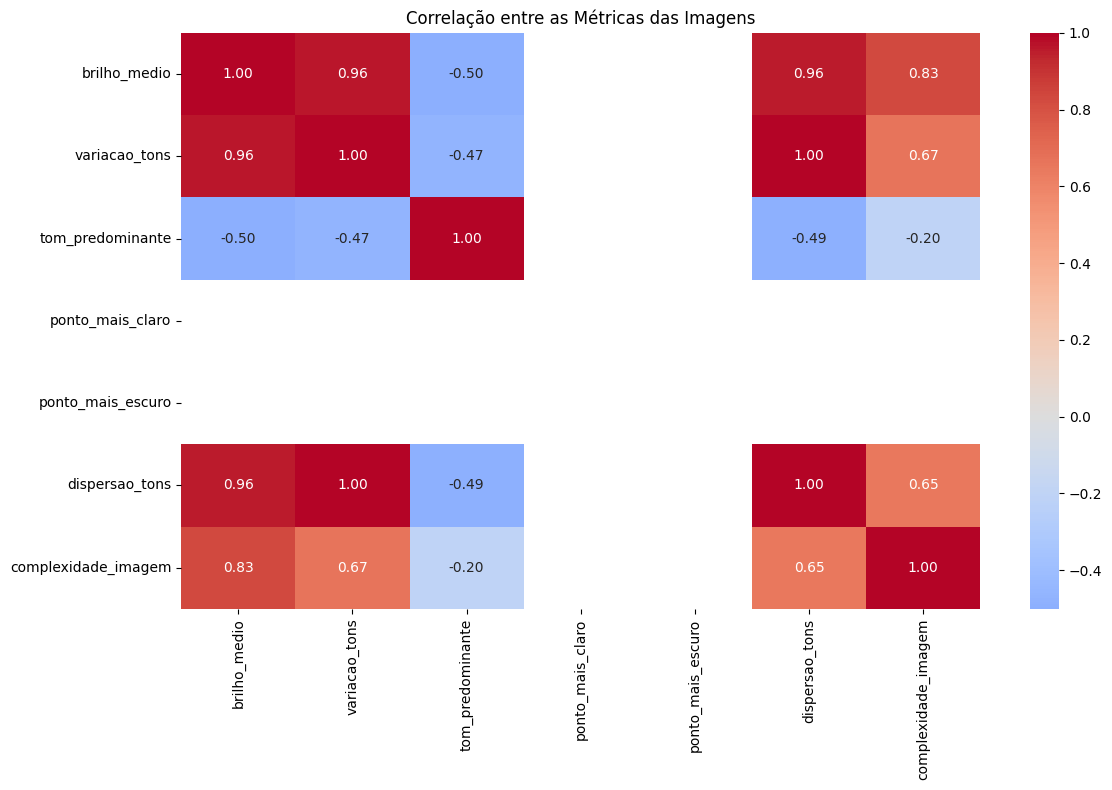


Correlações mais significativas:
brilho_medio x variacao_tons: 0.96
brilho_medio x tom_predominante: -0.50
brilho_medio x dispersao_tons: 0.96
brilho_medio x complexidade_imagem: 0.83
dispersao_tons x variacao_tons: 1.00
complexidade_imagem x variacao_tons: 0.67
complexidade_imagem x dispersao_tons: 0.65


In [75]:
# Calcular e mostrar correlações
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar mapa de calor das correlações
sns.heatmap(df_features_renamed.corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')

plt.title('Correlação entre as Métricas das Imagens')
plt.tight_layout()
plt.show()

# Explicar as correlações mais fortes
corr_matrix = df_features_renamed.corr()
print('\nCorrelações mais significativas:')
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 < col2 and abs(corr_matrix.loc[col1, col2]) > 0.5:
            print(f'{col1} x {col2}: {corr_matrix.loc[col1, col2]:.2f}')

## 4. Conectar com Apache Superset

Para conectar este banco ao Apache Superset:

1. Acesse o Superset em http://localhost:8088
2. Vá em 'Data -> Database Connections'
3. Clique em '+ Database'
4. Selecione 'PostgreSQL' como tipo de banco
5. Configure a conexão:
   - Nome: Análise de Imagens
   - URI: postgresql://superset:superset@db:5432/superset

Agora você pode:
1. Criar datasets a partir das tabelas
2. Usar as descrições amigáveis nas visualizações
3. Criar dashboards interativos